In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import kmapper as km
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy.stats import iqr
import networkx as nx
import hdbscan
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
df_departures = pd.read_pickle("../../calculated_distances_dep.pkl")

df_arrivals = pd.read_pickle("../../calculated_distances_arr.pkl")

print("Columns all:")
print(df_departures.columns.tolist())

Columns all:
['airportCode', 'date', 'deviation', 'delay']


In [3]:
df_arrivals_long_delay = df_arrivals[df_arrivals['delay'] < -500]
print(df_arrivals_long_delay)

       airportCode       date    deviation       delay
565414        LEAB 2018-09-22  1943.935833 -556.766667


In [4]:
# Filter month july

df_departures = df_departures[df_departures['date'].dt.month == 6]

df_arrivals = df_arrivals[df_arrivals['date'].dt.month == 6]

In [5]:
df_dep_by_airport = df_departures.groupby(['airportCode']).agg({
    'deviation': ['mean', 'median', 'std', iqr],
    'delay': ['mean', 'median', 'std', iqr]
}).reset_index()

df_dep_by_airport.columns = ['airportCode',
                            'deviation_mean', 'deviation_median', 'deviation_std', 'deviation_iqr',
                            'delay_mean', 'delay_median', 'delay_std', 'delay_iqr']

df_arr_by_airport = df_arrivals.groupby(['airportCode']).agg({
    'deviation': ['mean', 'median', 'std', iqr],
    'delay': ['mean', 'median', 'std', iqr]
}).reset_index()


df_arr_by_airport.columns = ['airportCode',
                            'deviation_mean', 'deviation_median', 'deviation_std', 'deviation_iqr',
                            'delay_mean', 'delay_median', 'delay_std', 'delay_iqr']

df_all_by_airport = pd.merge(df_dep_by_airport, df_arr_by_airport, on=['airportCode'], suffixes=('_dep', '_arr'))



print(df_all_by_airport.head())

print(df_all_by_airport.shape)

  airportCode  deviation_mean_dep  deviation_median_dep  deviation_std_dep  \
0        GCFV         2349.673899           1351.731239        2664.935147   
1        GCGM          262.782600            206.911564         167.562617   
2        GCHI          346.373684            320.328106         164.675987   
3        GCLA          764.704469            299.168257        1461.731387   
4        GCLP         1487.709627            503.589849        2106.638392   

   deviation_iqr_dep  delay_mean_dep  delay_median_dep  delay_std_dep  \
0        2373.096170       -0.562514         -3.016667      14.431759   
1         229.944289       -4.364516         -5.083333       8.862576   
2         214.353196       -3.614815         -3.950000       8.886279   
3         315.859938       -1.989354         -2.916667       8.596939   
4        2049.707609        0.552077         -1.150000      12.931530   

   delay_iqr_dep  deviation_mean_arr  deviation_median_arr  deviation_std_arr  \
0        15

In [6]:
df_dep_by_airport.fillna({'deviation_std': 0.0, 'delay_std': 0.0}, inplace=True)
print(df_dep_by_airport.isna().sum())

print()
df_arr_by_airport.fillna({'deviation_std': 0.0, 'delay_std': 0.0}, inplace=True)
print(df_arr_by_airport.isna().sum())


print()
df_all_by_airport.fillna({'deviation_std_dep': 0.0, 'delay_std_dep': 0.0, 'deviation_std_arr': 0.0, 'delay_std_arr': 0.0}, inplace=True)
print(df_all_by_airport.isna().sum())

airportCode         0
deviation_mean      0
deviation_median    0
deviation_std       0
deviation_iqr       0
delay_mean          0
delay_median        0
delay_std           0
delay_iqr           0
dtype: int64

airportCode         0
deviation_mean      0
deviation_median    0
deviation_std       0
deviation_iqr       0
delay_mean          0
delay_median        0
delay_std           0
delay_iqr           0
dtype: int64

airportCode             0
deviation_mean_dep      0
deviation_median_dep    0
deviation_std_dep       0
deviation_iqr_dep       0
delay_mean_dep          0
delay_median_dep        0
delay_std_dep           0
delay_iqr_dep           0
deviation_mean_arr      0
deviation_median_arr    0
deviation_std_arr       0
deviation_iqr_arr       0
delay_mean_arr          0
delay_median_arr        0
delay_std_arr           0
delay_iqr_arr           0
dtype: int64


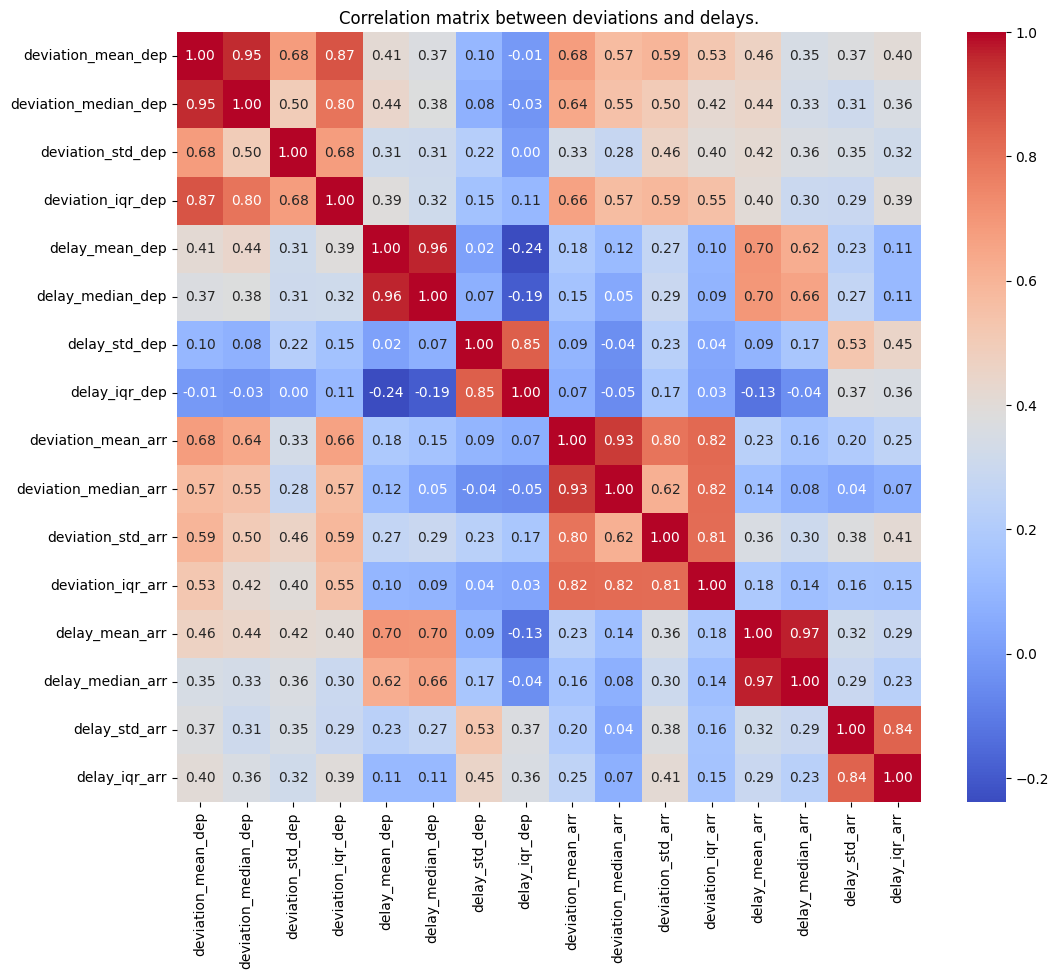

In [7]:
df_numeric = df_all_by_airport.drop(columns=['airportCode'])

corr_matrix = df_numeric.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix between deviations and delays.")
plt.show()

In [8]:
df_spanish_airports = pd.read_pickle('../../spanish_airports.pkl')

X_all = df_all_by_airport.drop(columns=['airportCode']).dropna()

print(X_all.head())
print()

scaler = StandardScaler()
X_scaled_all = scaler.fit_transform(X_all)

custom_tooltips_all = np.array([
     f"{df_spanish_airports.loc[df_spanish_airports['ICAO'] == row['airportCode'], 'Aeropuerto'].values[0] }" for _, row in df_all_by_airport.iterrows()
])

print(X_scaled_all)

   deviation_mean_dep  deviation_median_dep  deviation_std_dep  \
0         2349.673899           1351.731239        2664.935147   
1          262.782600            206.911564         167.562617   
2          346.373684            320.328106         164.675987   
3          764.704469            299.168257        1461.731387   
4         1487.709627            503.589849        2106.638392   

   deviation_iqr_dep  delay_mean_dep  delay_median_dep  delay_std_dep  \
0        2373.096170       -0.562514         -3.016667      14.431759   
1         229.944289       -4.364516         -5.083333       8.862576   
2         214.353196       -3.614815         -3.950000       8.886279   
3         315.859938       -1.989354         -2.916667       8.596939   
4        2049.707609        0.552077         -1.150000      12.931530   

   delay_iqr_dep  deviation_mean_arr  deviation_median_arr  deviation_std_arr  \
0        15.1750         3032.563604           3713.065678        2626.399088   
1 

In [9]:
def graph_stats(graph):
    G = nx.Graph()
    for node_id in graph['nodes'].keys():
        members = graph['nodes'][node_id]
        nombres_miembros = [custom_tooltips_all[i] for i in members]
        G.add_node(node_id, members=nombres_miembros)
    
    for source, targets in graph['links'].items():
        for target in targets:
            G.add_edge(source, target)

    num_nodos = len(graph['nodes'])
    num_enlaces = len(graph['links'])
    densidad = (2 * num_enlaces) / (num_nodos * (num_nodos - 1)) if num_nodos > 1 else 0
    grados = dict(G.degree()).values()
    grado_medio = sum(grados) / len(grados) if len(grados) > 0 else 0
    grado_max = max(grados) if grados else 0
    grado_min = min(grados) if grados else 0
    num_componentes = nx.number_connected_components(G)
    tamaños = [ len(data['members']) 
            for _, data in G.nodes(data=True) ]
    
    tamaño_medio = sum(tamaños) / len(tamaños)
    diametro = nx.diameter(G) if nx.is_connected(G) else max(nx.diameter(G.subgraph(c)) for c in nx.connected_components(G))
    coef_agrupamiento = nx.average_clustering(G) if len(G) > 1 else 0

    centralidad_grado = nx.degree_centrality(G)
    centralidad_betweenness = nx.betweenness_centrality(G)

    print("Número de nodos:", num_nodos)
    print("Número de enlaces:", num_enlaces)
    print("Densidad del grafo:", densidad)
    print("Grados:", grados)
    print("Grado medio de los nodos:", grado_medio)
    print("Grado máximo:", grado_max)
    print("Grado mínimo:", grado_min)
    print("Número de componentes conectados:", num_componentes)
    print("Tamaño medio de cluster:", tamaño_medio)
    print("Tamaños:", tamaños)
    print("Diámetro del grafo:", diametro)
    print("Coeficiente medio de agrupamiento:", coef_agrupamiento)
    print("Centralidad grado:", centralidad_grado)
    print("Centralidad betweeness:", centralidad_betweenness)
    print()
    print("-" * 30)

    for node_id, data in G.nodes(data=True):
        if(data and data['members']):    
            members = data['members']
            cluster_size = len(members)
            print(f"Clúster: {node_id}")
            print(f" - Número de miembros: {cluster_size}")
            print(f" - Miembros: {[str(member) for member in members]}")
            print("-" * 30)
            
    from collections import defaultdict

    apariciones_miembro = defaultdict(int)

    for _, data in G.nodes(data=True):
        if data and 'members' in data:
            for miembro in data['members']:
                apariciones_miembro[miembro] += 1

    print("\nNúmero de nodos en los que aparece cada miembro:")
    for miembro, conteo in apariciones_miembro.items():
        if conteo > 1:
            print(f" - {miembro}: {conteo} nodos")   
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, font_size=12, font_weight='bold')
    
    plt.show()

Número de nodos: 21
Número de enlaces: 10
Densidad del grafo: 0.047619047619047616
Grados: dict_values([1, 2, 1, 0, 0, 0, 1, 1, 2, 1, 2, 1, 0, 1, 2, 2, 1, 0, 1, 1, 0])
Grado medio de los nodos: 0.9523809523809523
Grado máximo: 2
Grado mínimo: 0
Número de componentes conectados: 11
Tamaño medio de cluster: 3.0952380952380953
Tamaños: [2, 2, 2, 1, 1, 1, 3, 1, 10, 1, 15, 1, 1, 1, 8, 8, 1, 1, 2, 2, 1]
Diámetro del grafo: 5
Coeficiente medio de agrupamiento: 0.0
Centralidad grado: {'cube0_cluster0': 0.05, 'cube1_cluster0': 0.1, 'cube2_cluster0': 0.05, 'cube3_cluster0': 0.0, 'cube3_cluster1': 0.0, 'cube4_cluster0': 0.0, 'cube5_cluster0': 0.05, 'cube5_cluster1': 0.05, 'cube6_cluster0': 0.1, 'cube6_cluster1': 0.05, 'cube7_cluster0': 0.1, 'cube7_cluster1': 0.05, 'cube7_cluster2': 0.0, 'cube8_cluster0': 0.05, 'cube8_cluster1': 0.1, 'cube9_cluster0': 0.1, 'cube10_cluster0': 0.05, 'cube10_cluster1': 0.0, 'cube10_cluster2': 0.05, 'cube11_cluster0': 0.05, 'cube11_cluster1': 0.0}
Centralidad betweene

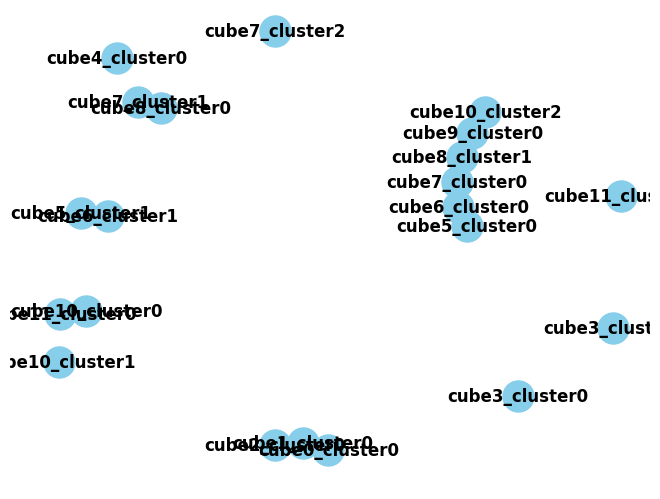

In [10]:
mapper = km.KeplerMapper()

pca = PCA(n_components=3)
filter_values_all = pca.fit_transform(X_scaled_all)

pca = PCA(n_components=1)

projection_all = pca.fit_transform(X_scaled_all)
 
graph_all = mapper.map(projection_all,
                       filter_values_all, 
                    clusterer=DBSCAN(eps=2.5, min_samples=1),
                    cover=km.Cover(n_cubes=12, perc_overlap=0.25)
)

color_values_all = X_scaled_all[:, :16]
color_function_name_all = X_all.columns[:16]

mapper.visualize(graph_all, 
                 path_html="mapper_output_all.html", 
                 custom_tooltips=custom_tooltips_all,
                 color_values=color_values_all,
                 color_function_name=color_function_name_all,
                 node_color_function=["mean", "std"])

graph_stats(graph_all)

Número de nodos: 10
Número de enlaces: 1
Densidad del grafo: 0.022222222222222223
Grados: dict_values([0, 1, 1, 0, 0, 0, 0, 0, 0, 0])
Grado medio de los nodos: 0.2
Grado máximo: 1
Grado mínimo: 0
Número de componentes conectados: 9
Tamaño medio de cluster: 2.5
Tamaños: [6, 2, 2, 2, 2, 3, 2, 2, 2, 2]
Diámetro del grafo: 1
Coeficiente medio de agrupamiento: 0.0
Centralidad grado: {'cube3_cluster0': 0.0, 'cube3_cluster1': 0.1111111111111111, 'cube4_cluster0': 0.1111111111111111, 'cube4_cluster1': 0.0, 'cube4_cluster2': 0.0, 'cube4_cluster3': 0.0, 'cube4_cluster4': 0.0, 'cube6_cluster0': 0.0, 'cube6_cluster1': 0.0, 'cube6_cluster2': 0.0}
Centralidad betweeness: {'cube3_cluster0': 0.0, 'cube3_cluster1': 0.0, 'cube4_cluster0': 0.0, 'cube4_cluster1': 0.0, 'cube4_cluster2': 0.0, 'cube4_cluster3': 0.0, 'cube4_cluster4': 0.0, 'cube6_cluster0': 0.0, 'cube6_cluster1': 0.0, 'cube6_cluster2': 0.0}

------------------------------
Clúster: cube3_cluster0
 - Número de miembros: 6
 - Miembros: ['Asturia

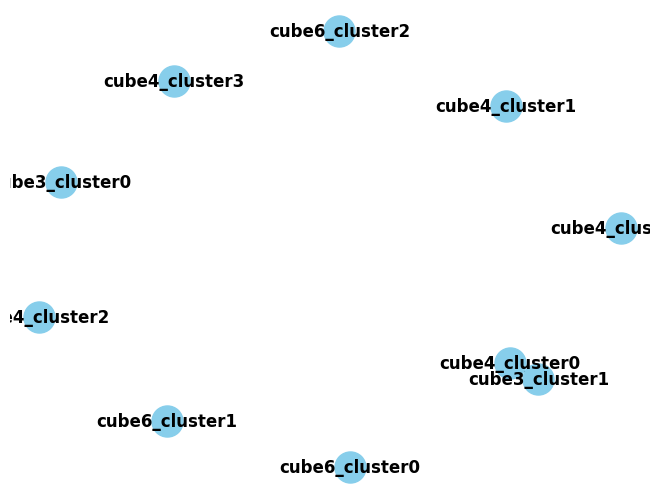

In [11]:
clusterer_all_ = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1)

graph_all_ = mapper.map(projection_all,
                         filter_values_all,
                         clusterer=clusterer_all_,
                         cover=km.Cover(n_cubes=7, perc_overlap=0.25)
)

mapper.visualize(graph_all_, 
                 path_html="mapper_output_all_.html",
                 custom_tooltips=custom_tooltips_all,
                 color_values=color_values_all,
                 color_function_name=color_function_name_all,
                 node_color_function=["mean", "std"])

graph_stats(graph_all_)

In [12]:
def get_airports_from_graph(graph, nodes=None):
    airports = set()
    if nodes is not None:
        for node_id in graph['nodes'].keys():
            members = graph['nodes'][node_id]
            if len(members) >= nodes:
                nombres_miembros = [custom_tooltips_all[i] for i in members]
                airports.update(nombres_miembros)
    else:
        for node_id in graph['nodes'].keys():
            members = graph['nodes'][node_id]
            nombres_miembros = [custom_tooltips_all[i] for i in members]
            airports.update(nombres_miembros)
        
    return airports

airports_DBSCAN = get_airports_from_graph(graph_all, 7)

airports_HDBSCAN = get_airports_from_graph(graph_all_)

airports_in_both = airports_DBSCAN & airports_HDBSCAN

print(f"Porcentaje de aeropuertos de DBSCAN {len(airports_in_both) / len(airports_DBSCAN) * 100}")
print(f"Porcentaje de aeropuertos de HDBSCAN {len(airports_in_both) / len(airports_HDBSCAN) * 100}")


Porcentaje de aeropuertos de DBSCAN 65.51724137931035
Porcentaje de aeropuertos de HDBSCAN 79.16666666666666
